# Mid Term Project
by:
Srini and Denny

<a id='content'></a>
### Table of content
<a href='#setup'>setup libraries</a>
- pandas, numpy
- sklearn

<a href='#helper_function'>helper functions</a>
- plot data

<a href='#data_functions'>data functions</a>
- interquartile
- droping tables
- transformation

<a href='#raw_data'>raw data</a>
- loading raw data
<li>
    <a href='#plot_raw'>plot raw data</a>
    <li>
    <a href='#heatmap'>heatmap</a>
    </li>
</li>

<a href='#analyze_raw_data'>analyze Raw Data</a>

<a href='#plot_regression'>plot regression graph</a>

<a href='#feature_importance'>feature importance</a>

<a href='#content'>back to content list</a>
<a id='setup'></a> 
### Setup

In [181]:
# import libraries

# dealing with data libs
import pandas as pd
import numpy as np


# dealing with date 
import datetime

# plotting libs
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.notebook import tqdm # progressbar for looping


# machine learning libs
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

import statsmodels.api as sm





<a href='#content'>back to content list</a>
<a id='helper_function'></a> 
### Helper Functions

In [182]:
# ploting all numerical data from dataframe

def plot_numeric(data):
    for i in data._get_numeric_data():
        fig , ax = plt.subplots(1,2, figsize=(15,7))
        plt.title(i)
        sns.boxplot(x=data[i], ax=ax[0])
        sns.histplot(data[i], ax=ax[1])

        plt.show()

<a id='data_functions'></a>
<a href='#content'>back to content list</a>
### Functions for optional data handling:

#### option 1 Interquartile

In [183]:
# rip data in interquartile range

def reduce_to_interquartile(data: pd.DataFrame, name: list) -> pd.DataFrame:
    Q1 = data[name].quantile(0.25)
    Q3 = data[name].quantile(0.75)
    IQR = Q3 - Q1    #IQR is interquartile range.
    filter = (data[name] >= Q1 - 1.5 * IQR) & (data[name] <= Q3 + 1.5 *IQR)
    data=data.loc[filter] 

    return data

#### option 2 remove

In [184]:
# remove column

def remove_column(data: pd.DataFrame, name: list) -> pd.DataFrame:
    data = data.drop(columns=name, inplace= True)

    return data

#### perform transformation operation on data

In [185]:
# transform operation

def aggregate_powertransform(data: pd.DataFrame, name: list, operation, lamda_value: float)-> pd.DataFrame:
    
    return data


<a id='raw_data'></a>
<a href='#content'>back to content list</a>
### load raw data

In [186]:
# load data and create work_copy

raw_data = pd.read_excel('../data/Data_MidTerm_Project_Real_State_Regression.xls')

work_copy = raw_data.copy()


### Data review

In [187]:
raw_data.dtypes

id                        int64
date             datetime64[ns]
bedrooms                  int64
bathrooms               float64
sqft_living               int64
sqft_lot                  int64
floors                  float64
waterfront                int64
view                      int64
condition                 int64
grade                     int64
sqft_above                int64
sqft_basement             int64
yr_built                  int64
yr_renovated              int64
zipcode                   int64
lat                     float64
long                    float64
sqft_living15             int64
sqft_lot15                int64
price                     int64
dtype: object

<a id='plot_raw'></a>
<a href='#content'>back to content list</a>
### Plotting raw data

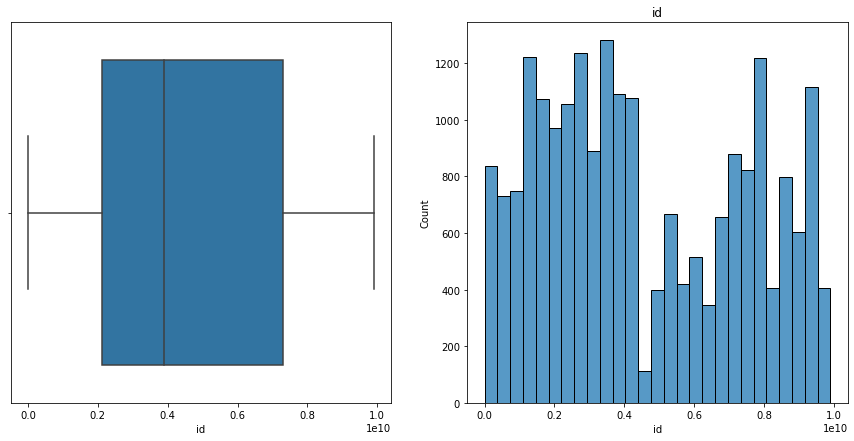

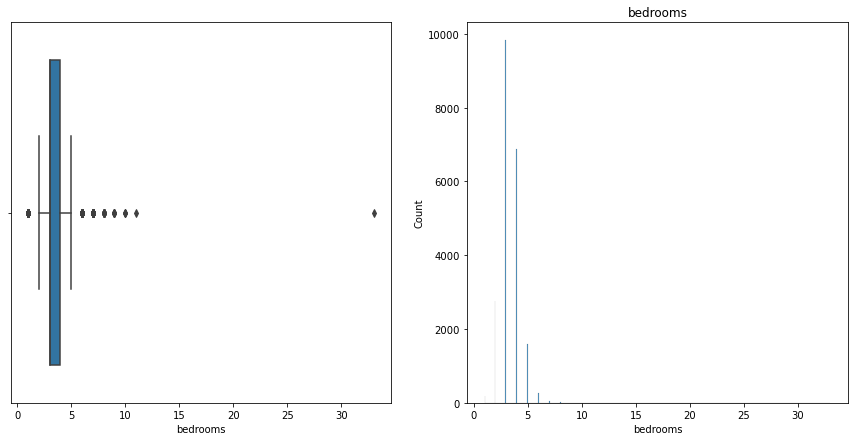

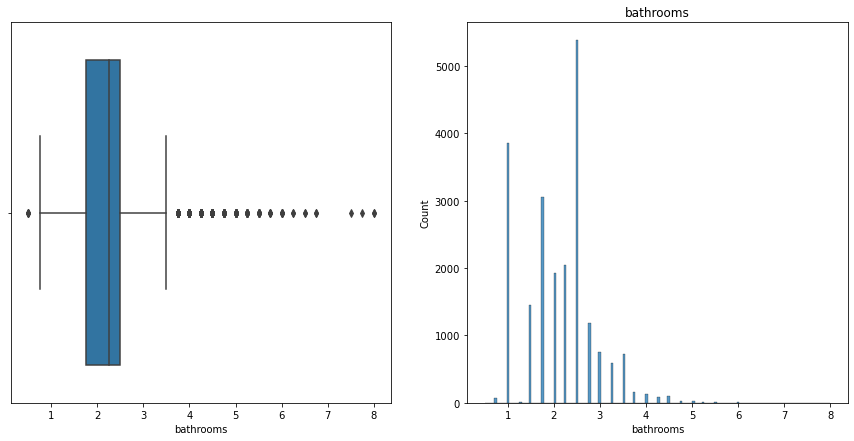

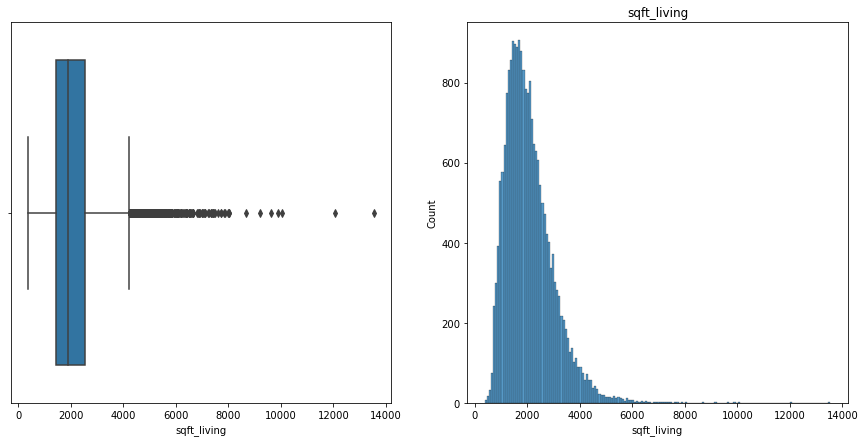

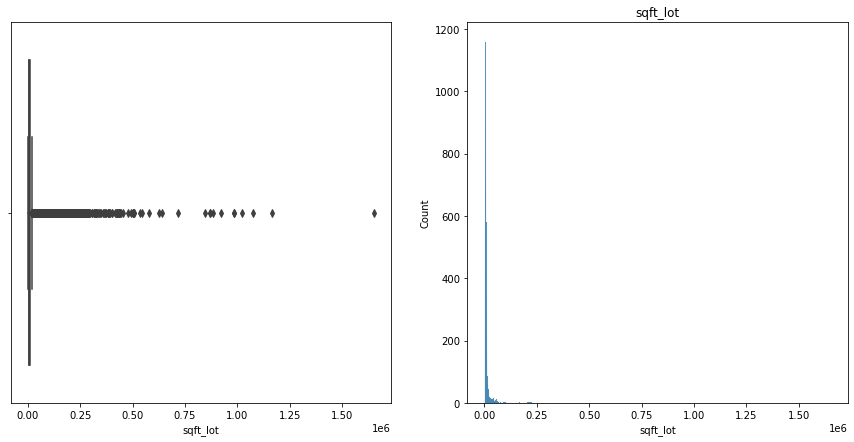

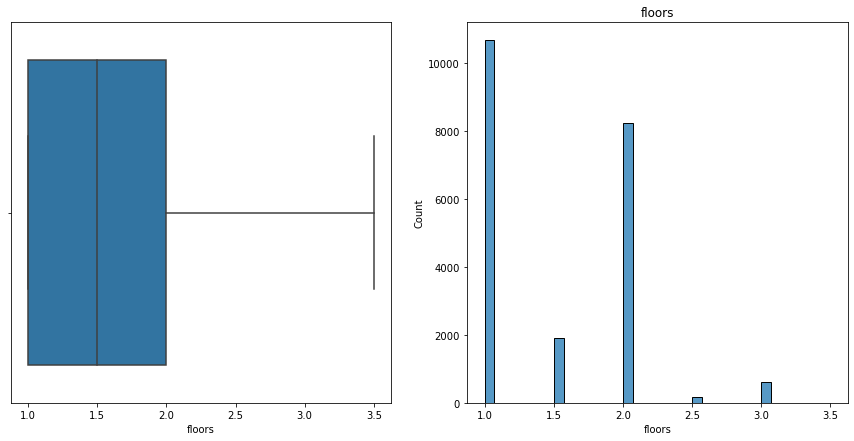

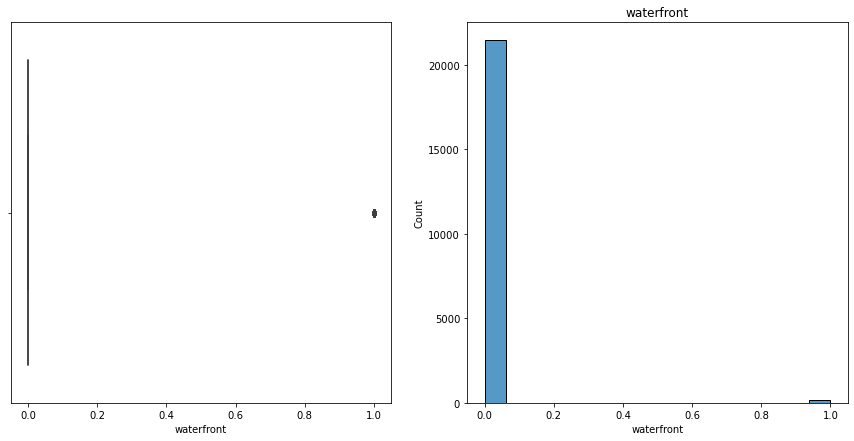

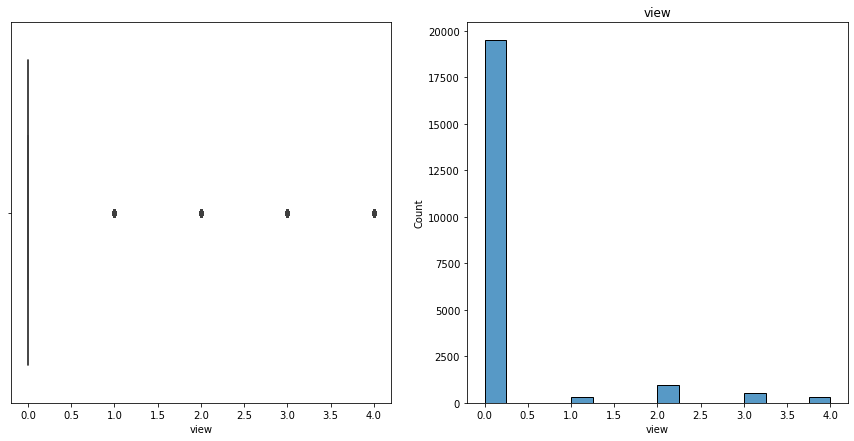

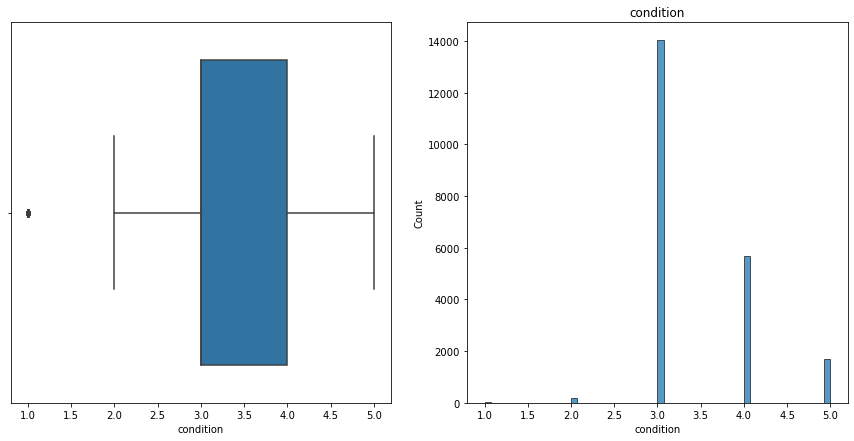

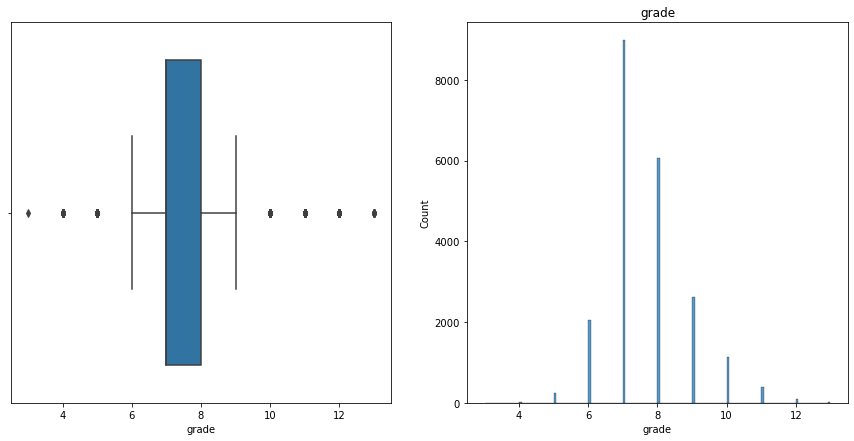

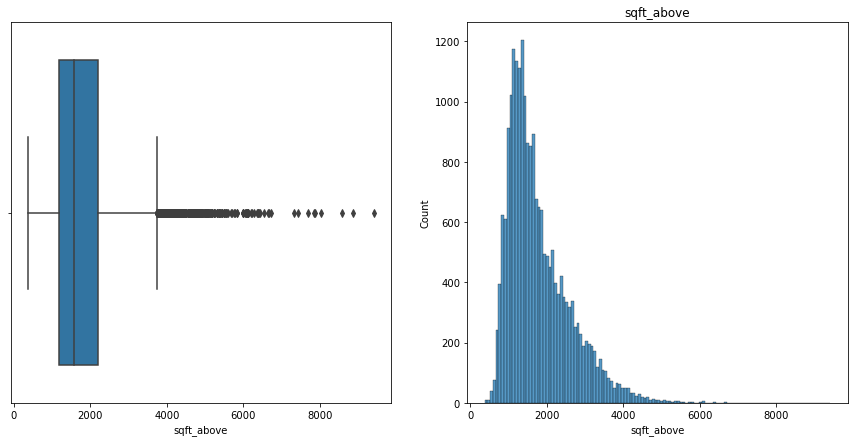

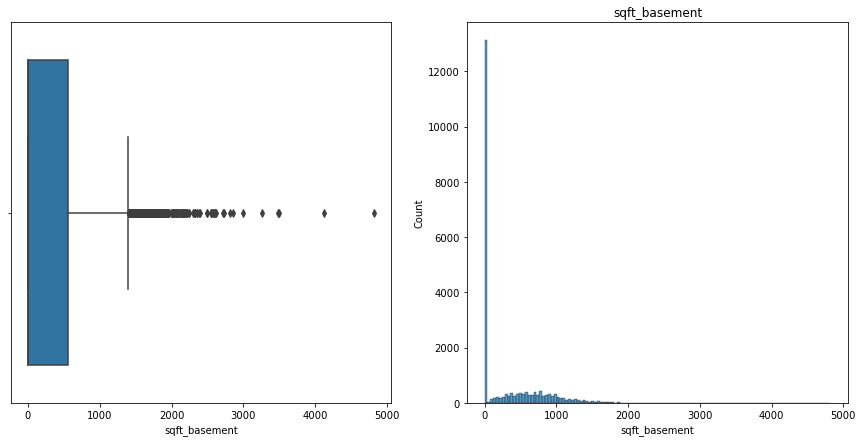

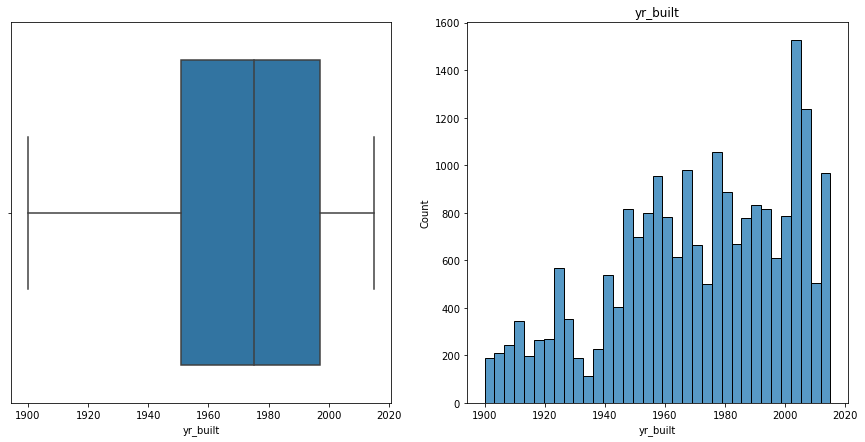

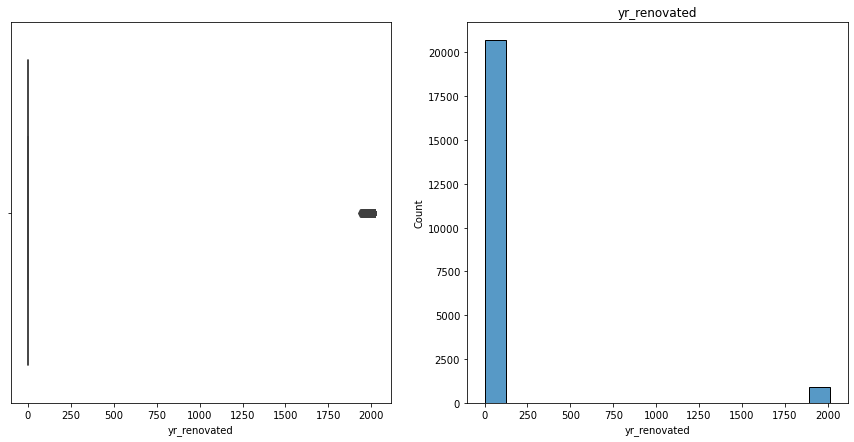

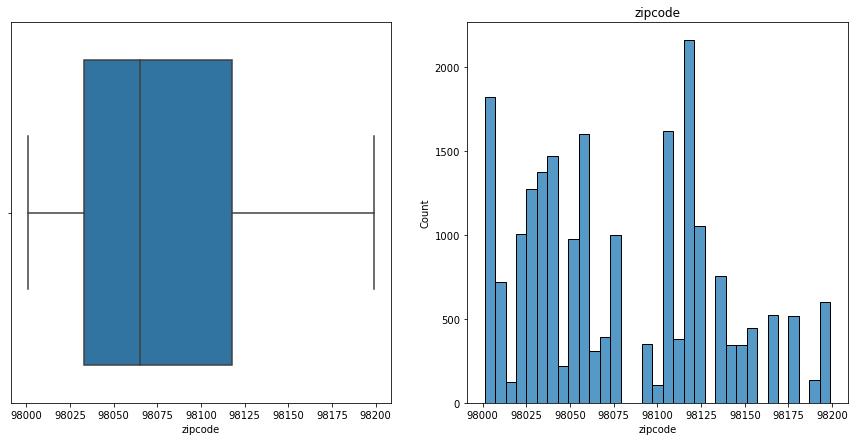

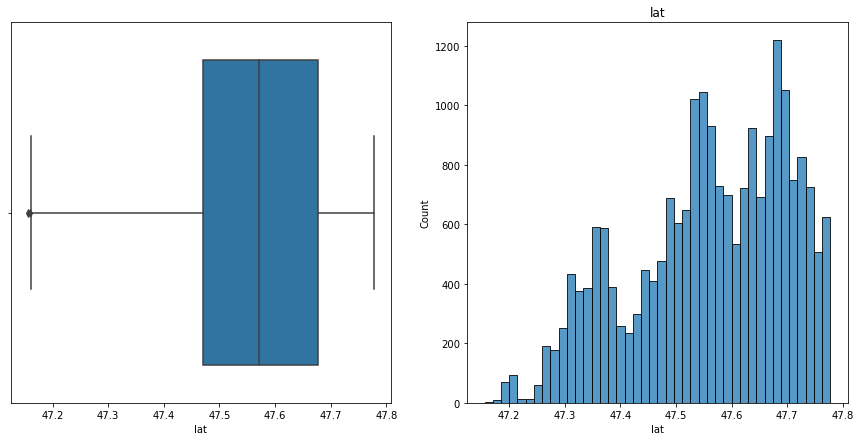

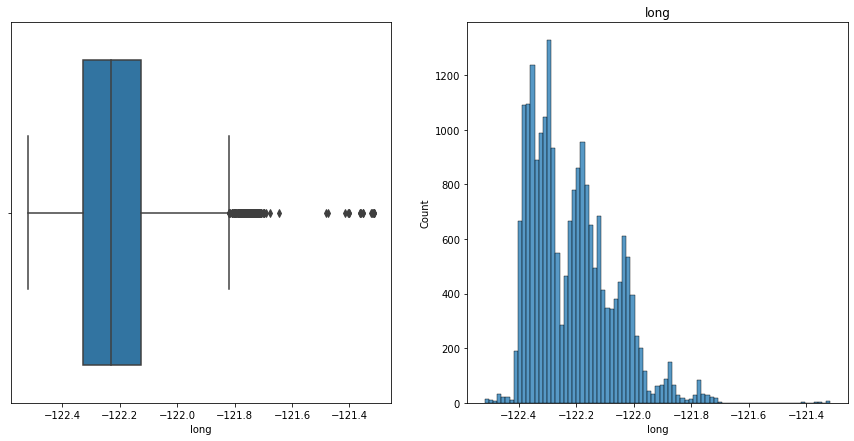

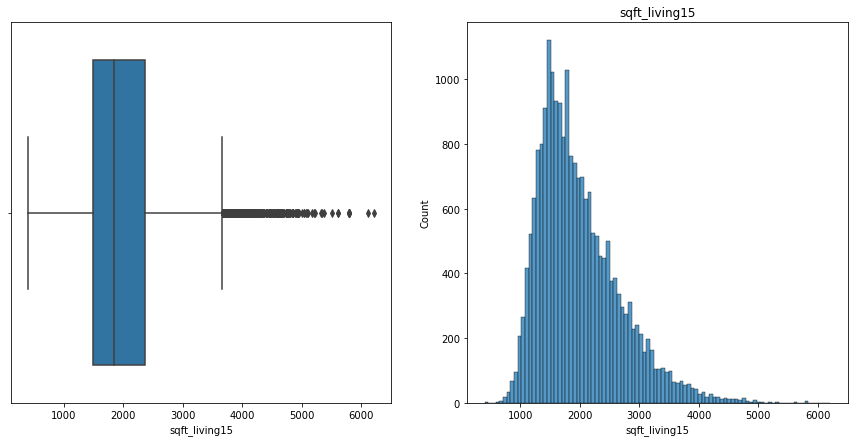

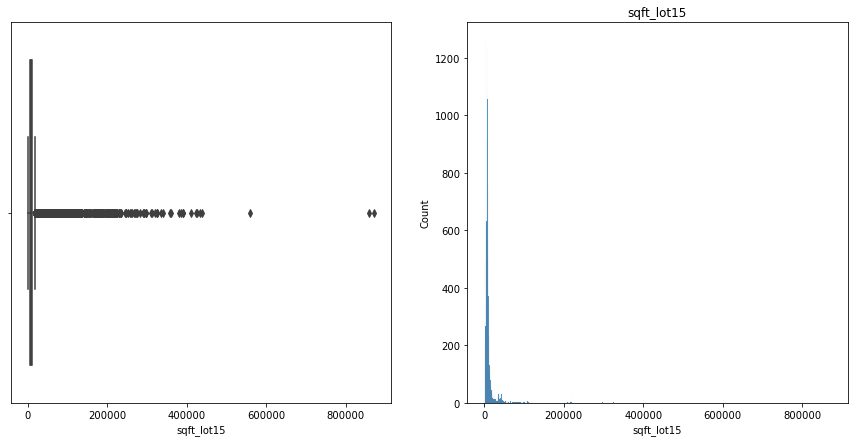

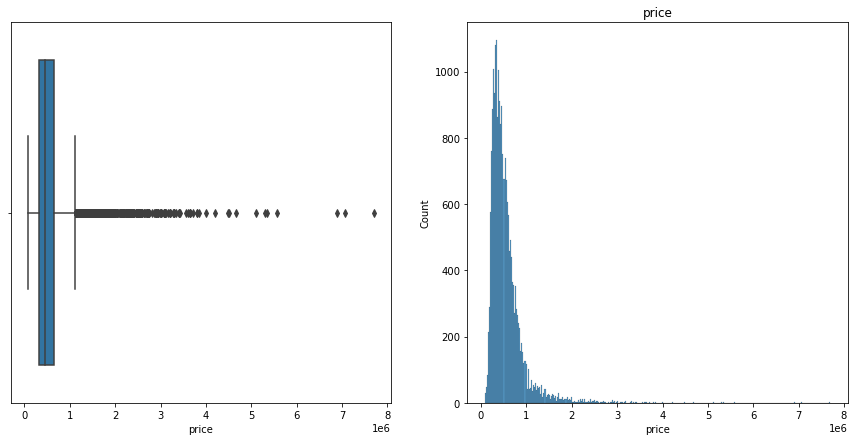

In [188]:
# analyze raw data
plot_numeric(work_copy)

<a id='heatmap'></a>
<a href='#content'>back to content list</a>

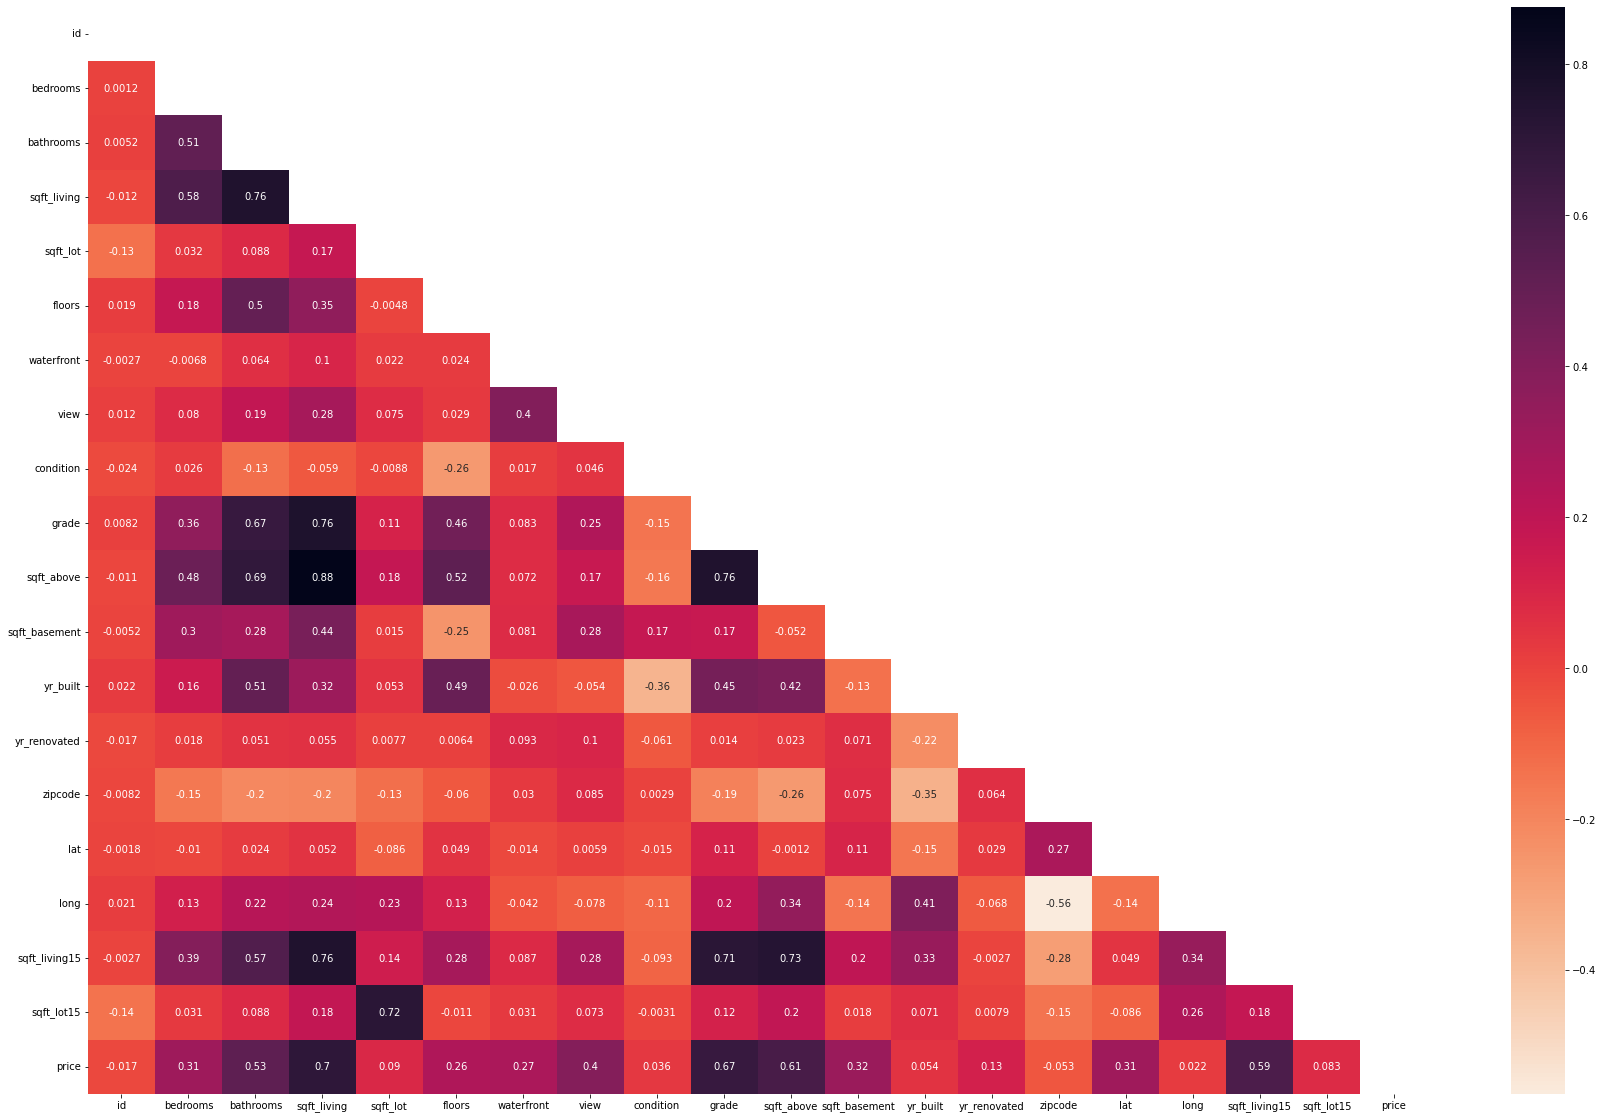

In [189]:
cmap = sns.cm.rocket_r  ## for reversing the colors
mask=np.zeros_like(work_copy._get_numeric_data().corr())
mask[np.triu_indices_from(mask)]=True
fig, ax=plt.subplots(figsize=(30, 20))
ax=sns.heatmap(work_copy._get_numeric_data().corr(), mask=mask, annot=True,cmap=cmap)
plt.show()

<a id='analyze_raw_data'></a>
<a href='#content'>back to content list</a>
### **Data description:** 

> id -> will be removed as not mandatory
>
> bedrooms -> need adjustments as max 33 could be an outlayer, without -> normal distributed
>
> bathrooms -> max 8 needs to check, if its fits with connected sqft range ->
>
> sqft_living -> maybe recalculated in square meter to fit better in european perspective
>
> sqft_lot -> similar to sqft_living
>
> floors -> maybe changable to ordonal categorical
>
> waterfront -> set to categorical 
>
> view -> needs review why min to 75% is zero with an max of 4
>
> condition -> transform to ordonal categorical 0-5
>
> grade -> as descripted typical ordonal categorical 0-13
>
> sqft_above -> similar to sqft_living
>
> sqft_basement -> similar to sqft_living
> - as sqft_basement looks without zero numbers as normal distributed
> - ***ToDo:*** drop zero values from this column
> - create category 'has_basement'
> - fill all 'has_basement' where basement is included
>
> yr_build -> use as number or could be ordonal category when binning with steps e.g 5 years 1900-1905 ....
>
> zip code, lat and long -> skipt or could binning or clustered to regions 
>
> sqft_living15 and sqft_lot15 represents the average living and lot sqft of the closest 15 neiboorhouses





In [190]:
# drop first not need data
work_copy.drop(columns=['id', 'date'], inplace=True)

#work_copy.drop(columns=['id', 'date', 'zipcode', 'lat', 'long', 'sqft_lot', 'yr_built'], inplace=True)
#work_copy.drop(columns='sqft_above', inplace=True)
#work_copy.drop(columns=['id', 'date', 'sqft_lot', 'floors', 'waterfront', 'condition', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long', 'sqft_lot15'], inplace=True)

In [191]:
# interquartile sqft_living

#work_copy = reduce_to_interquartile(data=work_copy, name='sqft_living')
#work_copy = reduce_to_interquartile(data=work_copy, name='sqft_above')
work_copy = reduce_to_interquartile(data=work_copy, name='price')

In [192]:
#plot_numeric(work_copy)

In [193]:
work_copy.describe()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,price
count,20439.000000,20439.000000,20439.000000,2.043900e+04,20439.000000,20439.000000,20439.000000,20439.000000,20439.000000,20439.000000,20439.000000,20439.000000,20439.000000,20439.000000,20439.000000,20439.000000,20439.000000,20439.000000,2.043900e+04
mean,3.330936,2.051886,1975.189931,1.458557e+04,1.475561,0.002984,0.172171,3.406625,7.530652,1708.118695,267.071236,1970.805079,74.783453,98078.578062,47.556892,-122.213337,1921.942218,12427.844709,4.767026e+05
std,0.908193,0.710196,773.797924,4.000982e+04,0.536629,0.054550,0.639990,0.647000,1.036060,726.912085,408.795267,29.159010,379.010916,53.347175,0.141049,0.142326,614.545667,26469.429212,2.077903e+05
min,1.000000,0.500000,370.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,3.000000,370.000000,0.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000,7.800000e+04
25%,3.000000,1.500000,1400.000000,5.000000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1170.000000,0.000000,1951.000000,0.000000,98033.000000,47.460400,-122.330000,1470.000000,5046.000000,3.150000e+05
50%,3.000000,2.000000,1860.000000,7.500000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1520.000000,0.000000,1974.000000,0.000000,98065.000000,47.566900,-122.232000,1800.000000,7542.000000,4.375000e+05
75%,4.000000,2.500000,2430.000000,1.031650e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2100.000000,510.000000,1996.000000,0.000000,98118.000000,47.679800,-122.123000,2280.000000,9880.000000,6.000000e+05
max,33.000000,7.500000,7480.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,12.000000,5710.000000,2720.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,5380.000000,871200.000000,1.120000e+06


### First Approach with unfilterd data

In [194]:
work_copy =  work_copy[work_copy['bedrooms'] != 33]

In [195]:
label = work_copy['price']
work_copy.drop(columns='price', inplace=True)

In [196]:
x_train, x_test, y_train, y_test = train_test_split(work_copy, label, test_size= 0.2, random_state= 42)

In [197]:
x_train.describe()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,16350.000000,16350.000000,16350.000000,1.635000e+04,16350.000000,16350.000000,16350.000000,16350.000000,16350.000000,16350.000000,16350.000000,16350.000000,16350.000000,16350.000000,16350.000000,16350.000000,16350.000000,16350.000000
mean,3.327645,2.051667,1974.870826,1.450624e+04,1.475107,0.002813,0.175902,3.406116,7.533884,1709.456881,265.413945,1970.771376,76.755474,98078.555596,47.556909,-122.212834,1923.953089,12381.061957
std,0.881220,0.710915,776.236438,3.994434e+04,0.536848,0.052969,0.645498,0.646033,1.043630,730.102611,407.964786,29.253647,383.753815,53.329917,0.140930,0.143040,617.018174,26373.961857
min,1.000000,0.500000,380.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,3.000000,380.000000,0.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000
25%,3.000000,1.500000,1400.000000,5.000000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1170.000000,0.000000,1951.000000,0.000000,98033.000000,47.461100,-122.330000,1470.000000,5044.250000
50%,3.000000,2.000000,1850.000000,7.500000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1520.000000,0.000000,1974.000000,0.000000,98065.000000,47.566500,-122.232000,1800.000000,7526.000000
75%,4.000000,2.500000,2430.000000,1.030000e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2108.750000,500.000000,1996.000000,0.000000,98118.000000,47.679775,-122.123000,2280.000000,9880.000000
max,11.000000,7.500000,7480.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,12.000000,5710.000000,2720.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,5380.000000,871200.000000


In [198]:
scaler_train = StandardScaler().fit(x_train)

scaler_train.transform(x_train)
scaler_train.transform(x_test)


array([[-0.37181992,  1.334002  ,  0.63787822, ..., -1.25259768,
         0.75534431, -0.1737017 ],
       [-0.37181992, -0.77601874, -0.68907765, ..., -0.43461919,
        -0.7843657 , -0.15208882],
       [-0.37181992, -0.42434862, -0.88232365, ...,  0.45327198,
        -0.83298812, -0.16482904],
       ...,
       [-2.64146926, -1.47935899, -1.02403739, ..., -0.77020011,
        -0.05502938, -0.0235111 ],
       [-0.37181992, -0.77601874,  0.72805969, ..., -0.65134853,
        -0.08744433, -0.21161905],
       [ 0.76300475, -0.07267849,  0.07102328, ...,  1.67674408,
        -0.58987601, 11.86858131]])

In [199]:
model_l = LinearRegression()

model_l.fit(x_train, y_train)

LinearRegression()

In [200]:
y_pred = model_l.predict(x_test)

In [201]:
x_train_sm = sm.add_constant(x_train) # adding a constant
model = sm.OLS(list(y_train), x_train_sm).fit()

print_model = model.summary()
print_model

/opt/anaconda3/envs/DA_Enviroment/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.694
Model:                            OLS   Adj. R-squared:                  0.694
Method:                 Least Squares   F-statistic:                     2180.
Date:                Mon, 15 Nov 2021   Prob (F-statistic):               0.00
Time:                        15:36:43   Log-Likelihood:            -2.1376e+05
No. Observations:               16350   AIC:                         4.276e+05
Df Residuals:                   16332   BIC:                         4.277e+05
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -6.998e+06   1.94e+06     -3.614      0.000   -1.08e+07    -3.2e+06
bedrooms      -1.062e+04   1338.587     -7.930      0.000   -1.32e+04   -7991.352
bathrooms      2.325e+04   2218.591     10.479      0.000    1.89e+04    2.76e+04
sqft_living      47.7262      1.655     28.839      0.000      44.482      50.970
sqft_lot          0.2234      0.032      6.875      0.000       0.160       0.287
floors         3.126e+04   2430.639     12.860      0.000    2.65e+04     3.6e+04
waterfront     1.102e+05   1.78e+04      6.181      0.000    7.52e+04    1.45e+05
view           3.016e+04   1551.306     19.442      0.000    2.71e+04    3.32e+04
condition      2.668e+04   1555.318     17.155      0.000    2.36e+04    2.97e+04
grade           7.24e+04   1470.120     49.246      0.000    6.95e+04    7.53e+04
sqft_above       25.4886      1.620     15.738      0.000      22.314      28.663
sqft_basement    22.2390      1.861     11.949      0.000      18.591      25.887
yr_built      -1767.1304     49.035    -36.038      0.000   -1863.243   -1671.017
yr_renovated     14.6601      2.502      5.859      0.000       9.755      19.565
zipcode        -224.6824     21.801    -10.306      0.000    -267.415    -181.950
lat            5.412e+05   6972.261     77.616      0.000    5.27e+05    5.55e+05
long          -5.169e+04   8545.431     -6.049      0.000   -6.84e+04   -3.49e+04
sqft_living15    49.2915      2.458     20.053      0.000      44.474      54.110
sqft_lot15       -0.1520      0.050     -3.054      0.002      -0.250      -0.054
==============================================================================
Omnibus:                     1339.795   Durbin-Watson:                   1.982
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2446.266
Skew:                           0.583   Prob(JB):                         0.00
Kurtosis:                       4.494   Cond. No.                     5.77e+16
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 4.95e-20. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

<a id='plot_regression'></a>
<a href='#content'>back to content list</a>
### Plot Regression Graph

In [202]:
result=pd.DataFrame({"y_test":y_test,"y_pred":y_pred})

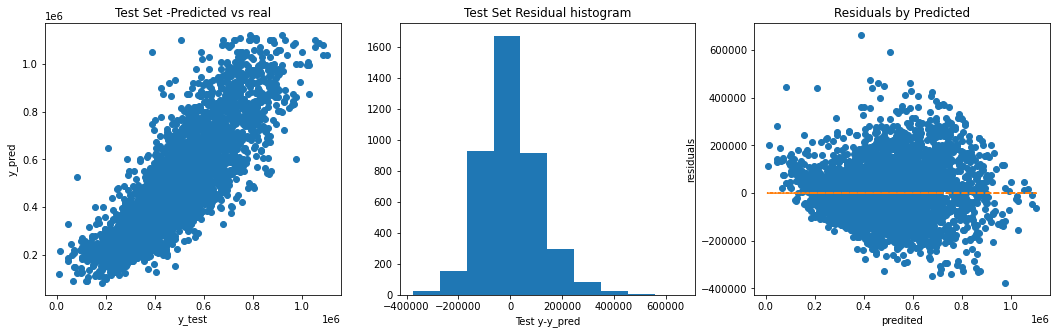

In [208]:
# Make an scatter plot y_pred vs y
# What kind of plot you will get if all the all the predictions are ok?
# A stright line

fig, ax = plt.subplots(1,3,figsize=(18,5))
ax[0].plot(y_pred, y_test, 'o')
ax[0].set_xlabel("y_test")
ax[0].set_ylabel("y_pred")
ax[0].set_title("Test Set -Predicted vs real")

# Get a histogram of the residuals ie: y - y_pred.  Homoscdasticity
# It resembles a normal distribution?
ax[1].hist(y_test - y_pred)
ax[1].set_xlabel("Test y-y_pred")
ax[1].set_title("Test Set Residual histogram")

ax[2].plot(y_pred,y_test - y_pred,"o")
ax[2].set_xlabel("predited")
ax[2].set_ylabel("residuals")
ax[2].set_title("Residuals by Predicted")
ax[2].plot(y_pred,np.zeros(len(y_pred)),linestyle='dashed')

<AxesSubplot:xlabel='y_pred', ylabel='y_test'>

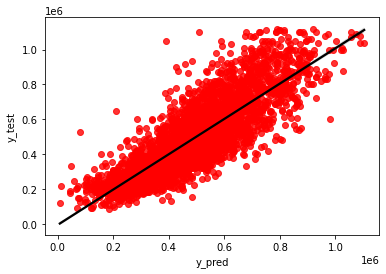

In [204]:
sns.regplot(x='y_pred',y='y_test', data=result, scatter_kws={"color": "red"}, line_kws={"color": "black"})

<a id='feature_importance'></a>
<a href='#content'>back to content list</a>

In [205]:
model_l.coef_

array([-1.06151294e+04,  2.32475907e+04,  4.77266764e+01,  2.23427353e-01,
        3.12581862e+04,  1.10178548e+05,  3.01604284e+04,  2.66809195e+04,
        7.23977241e+04,  2.54881545e+01,  2.22385221e+01, -1.76713043e+03,
        1.46600740e+01, -2.24682416e+02,  5.41156584e+05, -5.16920330e+04,
        4.92915346e+01, -1.52007535e-01])

In [206]:
features_importances = pd.DataFrame(data={
    'Attribute': x_train.columns,
    'Importance': abs(model_l.coef_)
})
features_importances = features_importances.sort_values(by='Importance', ascending=False)

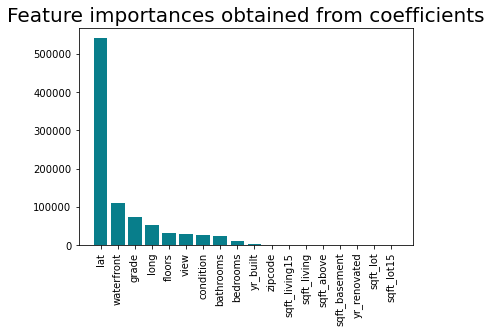

In [207]:
plt.bar(x=features_importances['Attribute'], height=features_importances['Importance'], color='#087E8B')
plt.title('Feature importances obtained from coefficients', size=20)
plt.xticks(rotation='vertical')
plt.show()